#Problemas de la guía 5
## S. Schiavinato - LU 153/11

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats #Contiene distribuciones útiles
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
%matplotlib inline
plt.rcParams["figure.figsize"] = (6 * (1 + np.sqrt(5)) / 2, 6)
plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["axes.labelsize"] = 20

:0: FutureWarning: IPython widgets are experimental and may change in the future.


Datos para ambos problemas

In [2]:
σ = 0.3
X = np.array([2.00,2.10,2.20,2.30,2.40,2.50,2.60,2.70,2.80,2.90,3.00])
Y = np.array([2.78,3.29,3.29,3.33,3.23,3.69,3.46,3.87,3.62,3.40,3.99])

Ajustes por cuadrados mínimos

In [3]:
def cuadrados_minimos(X, Y, σY):
    N = X.size
    Δ = N * np.sum(X**2) - np.sum(X)**2
    A1 = (np.sum(X**2) * np.sum(Y) - np.sum(X) * np.sum(X*Y))/Δ
    A2 = (N * np.sum(X*Y) - np.sum(X) * np.sum(Y))/Δ
    Σ11 = σY**2 / Δ * np.sum(X**2)
    Σ22 = σY**2/ Δ * N
    Σ12 = σY**2/Δ * (-np.sum(X))
    a = np.array([A1, A2])
    cov = np.array([[Σ11, Σ12],[Σ12, Σ22]])
    return a, cov

##Problema 6 
### Graficar los datos y ajustar una recta, con las bandas de error (con y sin covarianza considerada)

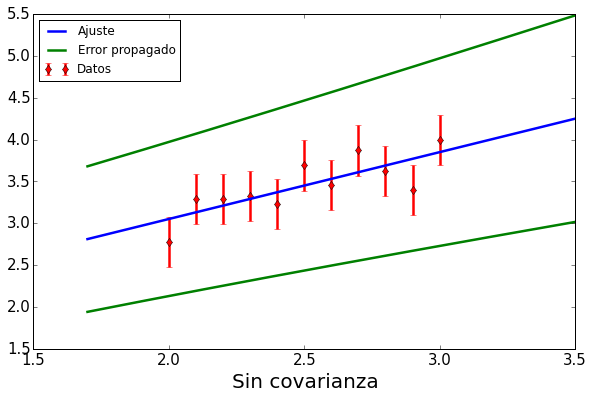

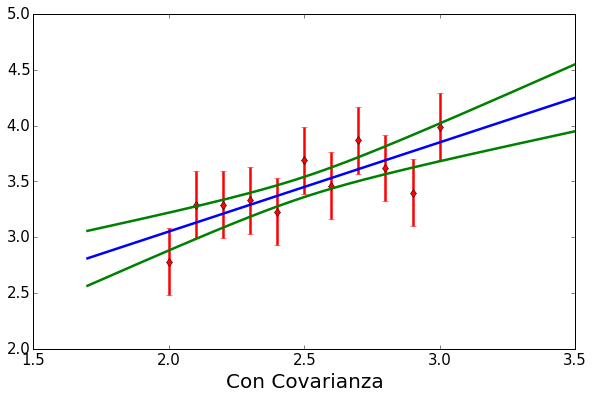

In [4]:
a, cov = cuadrados_minimos(X, Y, σ)

t = np.linspace(1.7, 3.5, 1000)
f = lambda x, a, b: a + b * x #Para ejecutarlo puedo usar f(t, *a) sii a es un lista o una tupla de dos elementos
#Funciones del error, con y sin covarianza
σYCov = lambda x, cov : np.sqrt(cov[0,0] + x**2 * cov[1,1] + 2 * x * cov[0,1])
σY = lambda x, cov : np.sqrt(cov[0,0] + x**2 * cov[1,1])

#Sin covarianza
plt.figure(1)
plt.errorbar(X,Y, yerr = σ, fmt = "rd", label = "Datos")
plt.plot(t,f(t, *a) + σY(t, cov), 'g-')
plt.plot(t, f(t, *a), 'b-', label = "Ajuste")
plt.plot(t, f(t, *a) - σY(t, cov), 'g-', label = "Error propagado");
plt.xlabel("Sin covarianza")
plt.legend(loc=0)

#Con covarianza
plt.figure(2)
plt.errorbar(X,Y, yerr = σ, fmt = "rd",  label = "Datos")
plt.plot(t,f(t, *a) + σYCov(t, cov), 'g-', label = "Error propagado")
plt.plot(t, f(t, *a), 'b-', label = "Ajuste")
plt.plot(t, f(t, *a) - σYCov(t, cov), 'g-');
plt.xlabel("Con Covarianza");

La banda de error sin covarianza no contempla que el error sea menor dentro de los datos experimentales, ya que en esa zona al interpolar es menos factible equivocarse. El error, si es razonable, debe aumentar si estamos interpolando para absisas sin datos experimentales cercanos, como se ve que pasa la considerar toda la matriz de covarianza.

In [5]:
i = σYCov(t, cov).argmin()
print("El error alcanza el valor mínimo de {:.2f} en x = {}".format(σYCov(t, cov)[i], t[i]))

El error alcanza el valor mínimo de 0.09 en x = 2.5


El valor este mínimo corresponde al centro de la absisas medidas, ya que ahí tenemos más seguridad de haber efectuado una interpolación exitosa

##Problema 7
### A partir de las rectas ajustadas, generar números al azar respecto al ajuste con distribución normal.

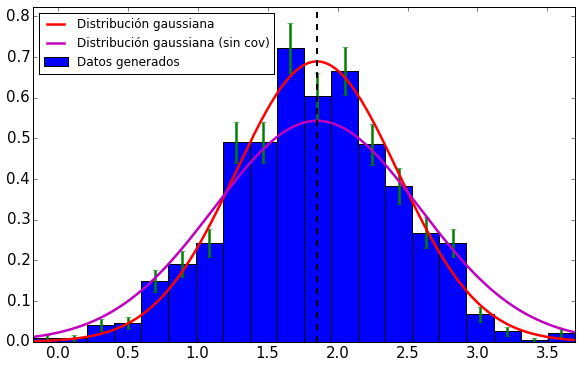

In [6]:
@interact(ya = (0.5, 4, 0.05)) #Código interactivo en IPython Notebook > v2
def G5_E7(ya = 0.5):
    A = []
    N = 1000 #Cantidad de cuentas
    a, cov = cuadrados_minimos(X, Y, σ) #Calculo los parámetros, para ingresar al generador de numeros aleatorios
    for i in range(N):
        Yr = []

        #Acá hay una diferencia. El enunciado pide efectuar el siguiente código 
        for i in np.nditer(X): #Creo un array Yr con valores aleatorios normales para cada x del vector X
            #La población es N(mu = a + b *x; sigma = σ), elemento 0 del ndarray
            Yr.append(np.random.normal(f(i, *a), σ, 1)[0])
    
        #Personalmente creo que lo que deberíamos hacer es
        #for i in nd.nditer(Y)
            #Yr.append(np.random.normal(i, σ, 1)[0])
        #Ya que de esta forma encontraría valores "experimentales" nuevos, consistente 
        #con los valores experimentales originales y a partir de ellos encontraría el ajuste 
        #y luego el valor interpolado. 
        #Con eso podría además encontrar numéricamente el intervalor de confianza
        
        Yr = np.array(Yr) #Transformo a array, tiene métodos útiles
        
        #Uso cuadrado mínimos con los datos aleatorios y obtengo una nueva recta
        ar, covr = cuadrados_minimos(X, Yr, σ) 
        A.append(f(ya, *ar)) #Guardo en un vector el valor predicho por el ajuste
        
    A = np.array(A)
    #Genero el histograma de los datos
    hist, bins = np.histogram(A, bins = 20)
    yerr = np.sqrt(hist) / (np.diff(bins) * hist.sum())
    hist = hist / (hist.sum() * np.diff(bins))
    plt.bar(bins[:-1], hist, width = np.diff(bins), yerr = yerr, ecolor = "g", label = "Datos generados") 
    t = np.linspace(np.amin(A), np.amax(A), 1000) #Creo el vector t para graficar la gaussiana acorde
    #La gaussiana debe tener la varianza igual al sigma propagado para y(x)
    plt.plot(t, stats.norm(f(ya, *a),σYCov(ya, cov)).pdf(t), 'r-', label = "Distribución gaussiana")
    #Para comparar, graficamos la covarianza
    plt.plot(t, stats.norm(f(ya, *a), σY(ya, cov)).pdf(t), 'm-', label = "Distribución gaussiana (sin cov)")
    #Además ponemos una línea con el valor medio
    plt.axvline(f(ya, *a), color = "k", linestyle = "--", linewidth = 2)
    plt.legend(loc=0);
    plt.xlim((bins.min(),bins.max()))
    plt.ylim((0, hist.max() + 0.1))